Keith Tyser

The process of exploring the dataset begins by loading the data using the numpy library and checking the shape of the data_X and data_Y arrays to determine the number of samples and the size of the images. Then, a sample of images is visualized to get an idea of the data. The distribution of the labels is also checked to see if the dataset is balanced. The pre-processing performed on the dataset includes normalizing the pixel values by dividing them by 255.0, cropping the images to a smaller size, and resizing the images to a consistent size of 32x32. Data quality issues that were observed include samples with NaN values in the data_Y array and samples with missing or corrupted data. These samples were removed from the dataset using the np.delete() function.

The model chosen is a convolutional neural network (CNN) which is appropriate for image classification tasks. The model is trained and evaluated by splitting the dataset into training and testing sets and training the model on the training set, then evaluating its performance on the testing set. The network architecture consists of several layers including an input layer, multiple convolutional layers with ReLU activation, max pooling layers, a flatten layer, dense layer, and a dropout layer. There are two output layers, each with 10 neurons and a softmax activation function, one for each digit. Hyperparameter tuning is done to find optimal kernel size, number of filters, and dropout rate. Final model with optimized hyperparameters is trained using 5-fold cross validation and receives an accuracy of ~92% on both digits.

The model is evaluated using the metrics of loss and accuracy. The loss metric used is categorical cross-entropy, which is commonly used for multi-class classification problems. The accuracy metric measures the proportion of correctly classified images. The performance of the model is ~92% accuracy on both digits.

To deploy the model as a service, the model could be containerized and deployed on a cloud service such as AWS or Google Cloud. Additionally, an API could be created to handle the incoming images, send them to the model for prediction, and return the predictions to the user. Another option would be to use a serverless solution like AWS Lambda to handle the image processing and prediction.

# Import data 

data_X shape: (62000, 64, 64)
data_Y shape: (62000, 2)


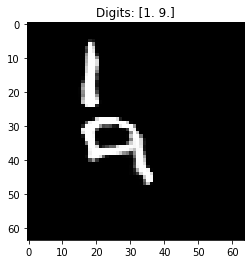

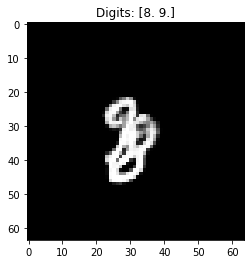

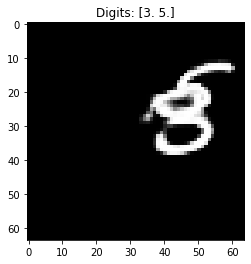

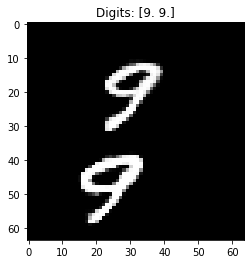

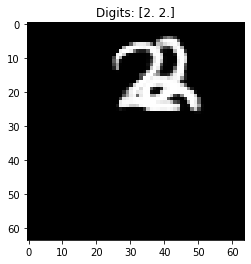

Label distribution: {0.0: 12114, 1.0: 12042, 2.0: 12167, 3.0: 11971, 4.0: 12108, 5.0: 11788, 6.0: 11933, 7.0: 11869, 8.0: 11915, 9.0: 12093, nan: 4000}


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_X = np.load('/content/drive/MyDrive/data (1)/data_X.npy')
data_Y = np.load('/content/drive/MyDrive/data (1)/data_Y.npy')

# Print the shape of the data_X and data_Y arrays to check the number of samples and the size of the images
print("data_X shape:", data_X.shape)
print("data_Y shape:", data_Y.shape)

# Visualize a sample of the images
sample_indices = np.random.randint(0, data_X.shape[0], size=5)
for i in sample_indices:
    plt.imshow(data_X[i], cmap='gray')
    plt.title("Digits: " + str(data_Y[i]))
    plt.show()
    
# Check the distribution of the labels
unique, counts = np.unique(data_Y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))



# Remove NaN values

In [2]:
# Find the indices of the samples with NaN values in the data_Y array
nan_indices = np.argwhere(np.isnan(data_Y))

# Remove the samples with NaN values from the data_X and data_Y arrays
data_X = np.delete(data_X, nan_indices, axis=0)
data_Y = np.delete(data_Y, nan_indices, axis=0)

# Print the new shape of the data_X and data_Y arrays to check the number of samples
print("data_X shape:", data_X.shape)
print("data_Y shape:", data_Y.shape)

data_X shape: (59999, 64, 64)
data_Y shape: (59999, 2)


# Normalize the images

In [3]:
# Normalize the pixel values
data_X = data_X / 255.0

# Crop the images
data_X = data_X[:, :50, :50]

In [4]:
import cv2

# Resize the images to a consistent size
new_size = (32, 32)
data_X = np.array([cv2.resize(img, new_size) for img in data_X])

# Check for any missing or corrupted data
missing_data_indices = []
for i, img in enumerate(data_X):
    if img.shape != new_size:
        missing_data_indices.append(i)

# Remove the samples with missing or corrupted data
data_X = np.delete(data_X, missing_data_indices, axis=0)
data_Y = np.delete(data_Y, missing_data_indices, axis=0)

# Print the new shape of the data_X and data_Y arrays to check the number of samples
print("data_X shape:", data_X.shape)
print("data_Y shape:", data_Y.shape)

data_X shape: (59999, 32, 32)
data_Y shape: (59999, 2)


# Baseline Model

In [15]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, concatenate
from keras.layers import Conv2D, MaxPooling2D


from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

# Reshape train_X and test_X and preprocess train_Y and test_Y
train_X = train_X.reshape(train_X.shape[0], 32, 32, 1)
test_X = test_X.reshape(test_X.shape[0], 32, 32, 1)

from keras.utils import to_categorical

train_Y1, train_Y2 = train_Y[:,0], train_Y[:,1]
test_Y1, test_Y2 = test_Y[:,0], test_Y[:,1]

train_Y1 = to_categorical(train_Y1, num_classes=10)
train_Y2 = to_categorical(train_Y2, num_classes=10)

test_Y1 = to_categorical(test_Y1, num_classes=10)
test_Y2 = to_categorical(test_Y2, num_classes=10)

# Create the model
inputs = Input(shape=(32, 32, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Add an output layer for each digit
output1 = Dense(10, activation='softmax', name='digit1')(x)
output2 = Dense(10, activation='softmax', name='digit2')(x)

model = Model(inputs, [output1, output2])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_X, [train_Y1, train_Y2], batch_size=64, epochs=10)

metrics_names = model.metrics_names
test_values = model.evaluate(test_X, [test_Y1, test_Y2], verbose=0)

for i in range(len(metrics_names)):
    print(metrics_names[i], test_values[i])

Epoch 1/10
750/750 [==============================] - 4s 4ms/step - loss: 3.6979 - digit1_loss: 1.7852 - digit2_loss: 1.9127 - digit1_accuracy: 0.3523 - digit2_accuracy: 0.2930
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 2.8165 - digit1_loss: 1.3245 - digit2_loss: 1.4920 - digit1_accuracy: 0.5325 - digit2_accuracy: 0.4663
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 2.4586 - digit1_loss: 1.1474 - digit2_loss: 1.3112 - digit1_accuracy: 0.5987 - digit2_accuracy: 0.5344
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 2.2395 - digit1_loss: 1.0460 - digit2_loss: 1.1935 - digit1_accuracy: 0.6344 - digit2_accuracy: 0.5788
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 2.0769 - digit1_loss: 0.9700 - digit2_loss: 1.1070 - digit1_accuracy: 0.6635 - digit2_accuracy: 0.6132
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 1.9467 - digit1_loss: 0.9123 - digit2_los

# Hyperparameter tuning

In [12]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 18.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=ffe76c7445ea6b5c8eecd7a158718041208a2fdf77061e16e8a9b5713c642732
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  

In [14]:
import optuna
from keras.layers import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


def optimize_model(trial):
    # Define the hyperparameters that you want to optimize
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    num_filters = trial.suggest_int('num_filters', 8, 128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5)
    
    # Create the model with the optimized hyperparameters
    inputs = Input(shape=(32, 32, 1))
    x = Conv2D(num_filters, kernel_size=(kernel_size, kernel_size), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(num_filters*2, kernel_size=(kernel_size, kernel_size), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output1 = Dense(10, activation='softmax', name='digit1')(x)
    output2 = Dense(10, activation='softmax', name='digit2')(x)
    model = Model(inputs, [output1, output2])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and return the validation loss
    model.fit(train_X, [train_Y1, train_Y2], batch_size=64, epochs=10, validation_data=(test_X, [test_Y1, test_Y2]))
    return model.evaluate(test_X, [test_Y1, test_Y2], verbose=0)[0]

study = optuna.create_study()
study.optimize(optimize_model, n_trials=50)
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-16 03:01:01,835] A new study created in memory with name: no-name-27ba9c2a-a11d-4bd1-8458-c7c5c4e7242a
<ipython-input-14-3974e6b679e6>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5)


Epoch 1/10
750/750 [==============================] - 13s 5ms/step - loss: 2.9984 - digit1_loss: 1.4070 - digit2_loss: 1.5914 - digit1_accuracy: 0.4994 - digit2_accuracy: 0.4235 - val_loss: 1.8156 - val_digit1_loss: 0.8136 - val_digit2_loss: 1.0020 - val_digit1_accuracy: 0.7204 - val_digit2_accuracy: 0.6530
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6576 - digit1_loss: 0.7462 - digit2_loss: 0.9114 - digit1_accuracy: 0.7447 - digit2_accuracy: 0.6853 - val_loss: 1.2200 - val_digit1_loss: 0.5433 - val_digit2_loss: 0.6767 - val_digit1_accuracy: 0.8146 - val_digit2_accuracy: 0.7785
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2171 - digit1_loss: 0.5568 - digit2_loss: 0.6603 - digit1_accuracy: 0.8127 - digit2_accuracy: 0.7786 - val_loss: 1.0030 - val_digit1_loss: 0.4542 - val_digit2_loss: 0.5488 - val_digit1_accuracy: 0.8474 - val_digit2_accuracy: 0.8169
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0

[I 2023-01-16 03:01:50,983] Trial 0 finished with value: 0.6685672998428345 and parameters: {'kernel_size': 5, 'num_filters': 77, 'dropout_rate': 0.23877066651573914}. Best is trial 0 with value: 0.6685672998428345.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.2926 - digit1_loss: 1.5665 - digit2_loss: 1.7261 - digit1_accuracy: 0.4396 - digit2_accuracy: 0.3710 - val_loss: 2.0131 - val_digit1_loss: 0.9029 - val_digit2_loss: 1.1102 - val_digit1_accuracy: 0.6970 - val_digit2_accuracy: 0.6329
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.9448 - digit1_loss: 0.9017 - digit2_loss: 1.0431 - digit1_accuracy: 0.6911 - digit2_accuracy: 0.6396 - val_loss: 1.3307 - val_digit1_loss: 0.6150 - val_digit2_loss: 0.7157 - val_digit1_accuracy: 0.8009 - val_digit2_accuracy: 0.7707
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4538 - digit1_loss: 0.6814 - digit2_loss: 0.7724 - digit1_accuracy: 0.7712 - digit2_accuracy: 0.7386 - val_loss: 1.0804 - val_digit1_loss: 0.4936 - val_digit2_loss: 0.5868 - val_digit1_accuracy: 0.8377 - val_digit2_accuracy: 0.8095
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:02:28,840] Trial 1 finished with value: 0.620613694190979 and parameters: {'kernel_size': 5, 'num_filters': 72, 'dropout_rate': 0.4859591705389539}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.7504 - digit1_loss: 1.7997 - digit2_loss: 1.9507 - digit1_accuracy: 0.3447 - digit2_accuracy: 0.2682 - val_loss: 2.9526 - val_digit1_loss: 1.3606 - val_digit2_loss: 1.5920 - val_digit1_accuracy: 0.5257 - val_digit2_accuracy: 0.4302
Epoch 2/10
750/750 [==============================] - 3s 5ms/step - loss: 2.8381 - digit1_loss: 1.3215 - digit2_loss: 1.5166 - digit1_accuracy: 0.5308 - digit2_accuracy: 0.4437 - val_loss: 2.3280 - val_digit1_loss: 1.0631 - val_digit2_loss: 1.2649 - val_digit1_accuracy: 0.6370 - val_digit2_accuracy: 0.5578
Epoch 3/10
750/750 [==============================] - 3s 5ms/step - loss: 2.4396 - digit1_loss: 1.1279 - digit2_loss: 1.3117 - digit1_accuracy: 0.5994 - digit2_accuracy: 0.5251 - val_loss: 2.0557 - val_digit1_loss: 0.9446 - val_digit2_loss: 1.1111 - val_digit1_accuracy: 0.6712 - val_digit2_accuracy: 0.6130
Epoch 4/10
750/750 [==============================] - 3s 5ms/step - loss: 2.

[I 2023-01-16 03:03:05,798] Trial 2 finished with value: 1.4879261255264282 and parameters: {'kernel_size': 2, 'num_filters': 57, 'dropout_rate': 0.48599001187820906}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3683 - digit1_loss: 1.6001 - digit2_loss: 1.7682 - digit1_accuracy: 0.4295 - digit2_accuracy: 0.3551 - val_loss: 2.5932 - val_digit1_loss: 1.1980 - val_digit2_loss: 1.3952 - val_digit1_accuracy: 0.5829 - val_digit2_accuracy: 0.5048
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2751 - digit1_loss: 1.0245 - digit2_loss: 1.2506 - digit1_accuracy: 0.6410 - digit2_accuracy: 0.5558 - val_loss: 1.9693 - val_digit1_loss: 0.8718 - val_digit2_loss: 1.0975 - val_digit1_accuracy: 0.6958 - val_digit2_accuracy: 0.6183
Epoch 3/10
750/750 [==============================] - 3s 5ms/step - loss: 1.8584 - digit1_loss: 0.8334 - digit2_loss: 1.0249 - digit1_accuracy: 0.7083 - digit2_accuracy: 0.6422 - val_loss: 1.7563 - val_digit1_loss: 0.7729 - val_digit2_loss: 0.9834 - val_digit1_accuracy: 0.7322 - val_digit2_accuracy: 0.6568
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:03:43,344] Trial 3 finished with value: 1.1659303903579712 and parameters: {'kernel_size': 5, 'num_filters': 16, 'dropout_rate': 0.061920073546482934}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 3.8614 - digit1_loss: 1.8759 - digit2_loss: 1.9855 - digit1_accuracy: 0.3207 - digit2_accuracy: 0.2620 - val_loss: 3.1934 - val_digit1_loss: 1.4992 - val_digit2_loss: 1.6942 - val_digit1_accuracy: 0.4775 - val_digit2_accuracy: 0.4029
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 3.0668 - digit1_loss: 1.4412 - digit2_loss: 1.6255 - digit1_accuracy: 0.4983 - digit2_accuracy: 0.4227 - val_loss: 2.6854 - val_digit1_loss: 1.2419 - val_digit2_loss: 1.4435 - val_digit1_accuracy: 0.5673 - val_digit2_accuracy: 0.4942
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.7501 - digit1_loss: 1.2821 - digit2_loss: 1.4680 - digit1_accuracy: 0.5554 - digit2_accuracy: 0.4821 - val_loss: 2.4864 - val_digit1_loss: 1.1457 - val_digit2_loss: 1.3407 - val_digit1_accuracy: 0.6003 - val_digit2_accuracy: 0.5354
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 2.

[I 2023-01-16 03:04:20,435] Trial 4 finished with value: 2.023577928543091 and parameters: {'kernel_size': 4, 'num_filters': 13, 'dropout_rate': 0.49316059853800776}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.1514 - digit1_loss: 1.5146 - digit2_loss: 1.6368 - digit1_accuracy: 0.4634 - digit2_accuracy: 0.4099 - val_loss: 2.3108 - val_digit1_loss: 1.0834 - val_digit2_loss: 1.2274 - val_digit1_accuracy: 0.6267 - val_digit2_accuracy: 0.5819
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.1348 - digit1_loss: 1.0117 - digit2_loss: 1.1230 - digit1_accuracy: 0.6486 - digit2_accuracy: 0.6157 - val_loss: 1.8779 - val_digit1_loss: 0.8864 - val_digit2_loss: 0.9915 - val_digit1_accuracy: 0.6980 - val_digit2_accuracy: 0.6695
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7716 - digit1_loss: 0.8429 - digit2_loss: 0.9286 - digit1_accuracy: 0.7087 - digit2_accuracy: 0.6830 - val_loss: 1.6950 - val_digit1_loss: 0.8024 - val_digit2_loss: 0.8926 - val_digit1_accuracy: 0.7217 - val_digit2_accuracy: 0.7000
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:05:00,645] Trial 5 finished with value: 1.5751451253890991 and parameters: {'kernel_size': 4, 'num_filters': 103, 'dropout_rate': 0.10229007658591016}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 3.7412 - digit1_loss: 1.7910 - digit2_loss: 1.9502 - digit1_accuracy: 0.3563 - digit2_accuracy: 0.2686 - val_loss: 3.1117 - val_digit1_loss: 1.4413 - val_digit2_loss: 1.6705 - val_digit1_accuracy: 0.4948 - val_digit2_accuracy: 0.4017
Epoch 2/10
750/750 [==============================] - 3s 5ms/step - loss: 2.8636 - digit1_loss: 1.3339 - digit2_loss: 1.5297 - digit1_accuracy: 0.5275 - digit2_accuracy: 0.4434 - val_loss: 2.4356 - val_digit1_loss: 1.1207 - val_digit2_loss: 1.3149 - val_digit1_accuracy: 0.6008 - val_digit2_accuracy: 0.5378
Epoch 3/10
750/750 [==============================] - 3s 5ms/step - loss: 2.4530 - digit1_loss: 1.1397 - digit2_loss: 1.3132 - digit1_accuracy: 0.5985 - digit2_accuracy: 0.5267 - val_loss: 2.1840 - val_digit1_loss: 1.0106 - val_digit2_loss: 1.1734 - val_digit1_accuracy: 0.6438 - val_digit2_accuracy: 0.5859
Epoch 4/10
750/750 [==============================] - 3s 5ms/step - loss: 2.

[I 2023-01-16 03:05:36,978] Trial 6 finished with value: 1.611404299736023 and parameters: {'kernel_size': 2, 'num_filters': 26, 'dropout_rate': 0.3478178592746605}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.7078 - digit1_loss: 1.7734 - digit2_loss: 1.9344 - digit1_accuracy: 0.3555 - digit2_accuracy: 0.2764 - val_loss: 2.8159 - val_digit1_loss: 1.2863 - val_digit2_loss: 1.5296 - val_digit1_accuracy: 0.5507 - val_digit2_accuracy: 0.4551
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.7591 - digit1_loss: 1.2834 - digit2_loss: 1.4757 - digit1_accuracy: 0.5432 - digit2_accuracy: 0.4659 - val_loss: 2.2404 - val_digit1_loss: 1.0235 - val_digit2_loss: 1.2170 - val_digit1_accuracy: 0.6482 - val_digit2_accuracy: 0.5753
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.3721 - digit1_loss: 1.0980 - digit2_loss: 1.2741 - digit1_accuracy: 0.6113 - digit2_accuracy: 0.5385 - val_loss: 2.0045 - val_digit1_loss: 0.9276 - val_digit2_loss: 1.0769 - val_digit1_accuracy: 0.6820 - val_digit2_accuracy: 0.6254
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 2.

[I 2023-01-16 03:06:15,084] Trial 7 finished with value: 1.368417501449585 and parameters: {'kernel_size': 2, 'num_filters': 65, 'dropout_rate': 0.48083744459077193}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.6935 - digit1_loss: 1.7792 - digit2_loss: 1.9143 - digit1_accuracy: 0.3518 - digit2_accuracy: 0.2867 - val_loss: 2.9248 - val_digit1_loss: 1.3642 - val_digit2_loss: 1.5605 - val_digit1_accuracy: 0.5191 - val_digit2_accuracy: 0.4413
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.8232 - digit1_loss: 1.3271 - digit2_loss: 1.4961 - digit1_accuracy: 0.5238 - digit2_accuracy: 0.4514 - val_loss: 2.3489 - val_digit1_loss: 1.0879 - val_digit2_loss: 1.2610 - val_digit1_accuracy: 0.6221 - val_digit2_accuracy: 0.5642
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4387 - digit1_loss: 1.1379 - digit2_loss: 1.3009 - digit1_accuracy: 0.5953 - digit2_accuracy: 0.5236 - val_loss: 2.0879 - val_digit1_loss: 0.9590 - val_digit2_loss: 1.1289 - val_digit1_accuracy: 0.6651 - val_digit2_accuracy: 0.6028
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 2.

[I 2023-01-16 03:06:53,128] Trial 8 finished with value: 1.4707485437393188 and parameters: {'kernel_size': 2, 'num_filters': 64, 'dropout_rate': 0.36086401824876335}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3254 - digit1_loss: 1.5713 - digit2_loss: 1.7541 - digit1_accuracy: 0.4350 - digit2_accuracy: 0.3556 - val_loss: 2.3293 - val_digit1_loss: 1.0545 - val_digit2_loss: 1.2749 - val_digit1_accuracy: 0.6247 - val_digit2_accuracy: 0.5494
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.1318 - digit1_loss: 0.9553 - digit2_loss: 1.1766 - digit1_accuracy: 0.6682 - digit2_accuracy: 0.5825 - val_loss: 1.7758 - val_digit1_loss: 0.7863 - val_digit2_loss: 0.9895 - val_digit1_accuracy: 0.7237 - val_digit2_accuracy: 0.6626
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7143 - digit1_loss: 0.7720 - digit2_loss: 0.9423 - digit1_accuracy: 0.7340 - digit2_accuracy: 0.6728 - val_loss: 1.4637 - val_digit1_loss: 0.6480 - val_digit2_loss: 0.8157 - val_digit1_accuracy: 0.7742 - val_digit2_accuracy: 0.7243
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:07:30,706] Trial 9 finished with value: 0.95468670129776 and parameters: {'kernel_size': 5, 'num_filters': 23, 'dropout_rate': 0.23384498103422685}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3126 - digit1_loss: 1.5860 - digit2_loss: 1.7266 - digit1_accuracy: 0.4329 - digit2_accuracy: 0.3678 - val_loss: 2.2648 - val_digit1_loss: 1.0511 - val_digit2_loss: 1.2137 - val_digit1_accuracy: 0.6377 - val_digit2_accuracy: 0.5842
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2319 - digit1_loss: 1.0497 - digit2_loss: 1.1822 - digit1_accuracy: 0.6363 - digit2_accuracy: 0.5838 - val_loss: 1.8513 - val_digit1_loss: 0.8759 - val_digit2_loss: 0.9754 - val_digit1_accuracy: 0.7005 - val_digit2_accuracy: 0.6730
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.8461 - digit1_loss: 0.8704 - digit2_loss: 0.9757 - digit1_accuracy: 0.7000 - digit2_accuracy: 0.6620 - val_loss: 1.5548 - val_digit1_loss: 0.7410 - val_digit2_loss: 0.8139 - val_digit1_accuracy: 0.7466 - val_digit2_accuracy: 0.7258
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:08:09,563] Trial 10 finished with value: 1.1603058576583862 and parameters: {'kernel_size': 3, 'num_filters': 128, 'dropout_rate': 0.3556964224280015}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.8149 - digit1_loss: 1.3354 - digit2_loss: 1.4795 - digit1_accuracy: 0.5268 - digit2_accuracy: 0.4689 - val_loss: 1.6082 - val_digit1_loss: 0.7453 - val_digit2_loss: 0.8629 - val_digit1_accuracy: 0.7477 - val_digit2_accuracy: 0.7104
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4189 - digit1_loss: 0.6615 - digit2_loss: 0.7574 - digit1_accuracy: 0.7749 - digit2_accuracy: 0.7421 - val_loss: 1.2477 - val_digit1_loss: 0.5676 - val_digit2_loss: 0.6800 - val_digit1_accuracy: 0.8043 - val_digit2_accuracy: 0.7750
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0165 - digit1_loss: 0.4776 - digit2_loss: 0.5389 - digit1_accuracy: 0.8404 - digit2_accuracy: 0.8183 - val_loss: 0.8445 - val_digit1_loss: 0.3984 - val_digit2_loss: 0.4462 - val_digit1_accuracy: 0.8671 - val_digit2_accuracy: 0.8509
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:08:48,779] Trial 11 finished with value: 0.7191789746284485 and parameters: {'kernel_size': 5, 'num_filters': 90, 'dropout_rate': 0.19151713784768146}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3116 - digit1_loss: 1.5952 - digit2_loss: 1.7164 - digit1_accuracy: 0.4305 - digit2_accuracy: 0.3844 - val_loss: 2.4488 - val_digit1_loss: 1.1466 - val_digit2_loss: 1.3022 - val_digit1_accuracy: 0.6113 - val_digit2_accuracy: 0.5541
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2878 - digit1_loss: 1.0854 - digit2_loss: 1.2023 - digit1_accuracy: 0.6232 - digit2_accuracy: 0.5833 - val_loss: 2.0036 - val_digit1_loss: 0.9588 - val_digit2_loss: 1.0448 - val_digit1_accuracy: 0.6672 - val_digit2_accuracy: 0.6485
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.9170 - digit1_loss: 0.9154 - digit2_loss: 1.0016 - digit1_accuracy: 0.6818 - digit2_accuracy: 0.6565 - val_loss: 1.7704 - val_digit1_loss: 0.8365 - val_digit2_loss: 0.9339 - val_digit1_accuracy: 0.7057 - val_digit2_accuracy: 0.6849
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:09:28,729] Trial 12 finished with value: 1.4748495817184448 and parameters: {'kernel_size': 4, 'num_filters': 91, 'dropout_rate': 0.16507358499512192}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3215 - digit1_loss: 1.5748 - digit2_loss: 1.7466 - digit1_accuracy: 0.4354 - digit2_accuracy: 0.3576 - val_loss: 2.1967 - val_digit1_loss: 0.9765 - val_digit2_loss: 1.2202 - val_digit1_accuracy: 0.6685 - val_digit2_accuracy: 0.5789
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0447 - digit1_loss: 0.9261 - digit2_loss: 1.1186 - digit1_accuracy: 0.6806 - digit2_accuracy: 0.6074 - val_loss: 1.5712 - val_digit1_loss: 0.6867 - val_digit2_loss: 0.8844 - val_digit1_accuracy: 0.7638 - val_digit2_accuracy: 0.7025
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.5575 - digit1_loss: 0.7122 - digit2_loss: 0.8453 - digit1_accuracy: 0.7532 - digit2_accuracy: 0.7083 - val_loss: 1.2486 - val_digit1_loss: 0.5770 - val_digit2_loss: 0.6716 - val_digit1_accuracy: 0.8048 - val_digit2_accuracy: 0.7774
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:10:06,350] Trial 13 finished with value: 0.904519259929657 and parameters: {'kernel_size': 5, 'num_filters': 45, 'dropout_rate': 0.3106540379679537}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.2926 - digit1_loss: 1.5748 - digit2_loss: 1.7178 - digit1_accuracy: 0.4331 - digit2_accuracy: 0.3728 - val_loss: 2.3941 - val_digit1_loss: 1.1063 - val_digit2_loss: 1.2878 - val_digit1_accuracy: 0.6155 - val_digit2_accuracy: 0.5474
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2660 - digit1_loss: 1.0634 - digit2_loss: 1.2026 - digit1_accuracy: 0.6290 - digit2_accuracy: 0.5749 - val_loss: 1.8787 - val_digit1_loss: 0.8738 - val_digit2_loss: 1.0049 - val_digit1_accuracy: 0.6995 - val_digit2_accuracy: 0.6531
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.8727 - digit1_loss: 0.8782 - digit2_loss: 0.9945 - digit1_accuracy: 0.6928 - digit2_accuracy: 0.6513 - val_loss: 1.6108 - val_digit1_loss: 0.7598 - val_digit2_loss: 0.8510 - val_digit1_accuracy: 0.7357 - val_digit2_accuracy: 0.7090
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:10:44,944] Trial 14 finished with value: 1.2296996116638184 and parameters: {'kernel_size': 3, 'num_filters': 79, 'dropout_rate': 0.28153227026852096}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.5943 - digit1_loss: 1.7249 - digit2_loss: 1.8695 - digit1_accuracy: 0.3835 - digit2_accuracy: 0.3131 - val_loss: 2.8092 - val_digit1_loss: 1.3024 - val_digit2_loss: 1.5068 - val_digit1_accuracy: 0.5447 - val_digit2_accuracy: 0.4711
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.6859 - digit1_loss: 1.2614 - digit2_loss: 1.4245 - digit1_accuracy: 0.5645 - digit2_accuracy: 0.4992 - val_loss: 2.3069 - val_digit1_loss: 1.0788 - val_digit2_loss: 1.2281 - val_digit1_accuracy: 0.6329 - val_digit2_accuracy: 0.5829
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.3180 - digit1_loss: 1.0883 - digit2_loss: 1.2296 - digit1_accuracy: 0.6258 - digit2_accuracy: 0.5758 - val_loss: 2.0517 - val_digit1_loss: 0.9507 - val_digit2_loss: 1.1010 - val_digit1_accuracy: 0.6805 - val_digit2_accuracy: 0.6301
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 2.

[I 2023-01-16 03:11:23,276] Trial 15 finished with value: 1.5532171726226807 and parameters: {'kernel_size': 4, 'num_filters': 42, 'dropout_rate': 0.40153979964899034}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.7765 - digit1_loss: 1.2909 - digit2_loss: 1.4856 - digit1_accuracy: 0.5459 - digit2_accuracy: 0.4640 - val_loss: 1.5830 - val_digit1_loss: 0.7168 - val_digit2_loss: 0.8662 - val_digit1_accuracy: 0.7592 - val_digit2_accuracy: 0.7062
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4333 - digit1_loss: 0.6582 - digit2_loss: 0.7752 - digit1_accuracy: 0.7751 - digit2_accuracy: 0.7353 - val_loss: 1.1177 - val_digit1_loss: 0.5082 - val_digit2_loss: 0.6095 - val_digit1_accuracy: 0.8314 - val_digit2_accuracy: 0.7977
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0292 - digit1_loss: 0.4776 - digit2_loss: 0.5516 - digit1_accuracy: 0.8369 - digit2_accuracy: 0.8156 - val_loss: 0.8283 - val_digit1_loss: 0.3829 - val_digit2_loss: 0.4454 - val_digit1_accuracy: 0.8747 - val_digit2_accuracy: 0.8513
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:12:03,138] Trial 16 finished with value: 0.7171359062194824 and parameters: {'kernel_size': 5, 'num_filters': 117, 'dropout_rate': 0.21567287802923657}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.7086 - digit1_loss: 1.2742 - digit2_loss: 1.4344 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.4858 - val_loss: 1.6996 - val_digit1_loss: 0.7782 - val_digit2_loss: 0.9215 - val_digit1_accuracy: 0.7333 - val_digit2_accuracy: 0.6844
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.3986 - digit1_loss: 0.6430 - digit2_loss: 0.7556 - digit1_accuracy: 0.7818 - digit2_accuracy: 0.7426 - val_loss: 1.2206 - val_digit1_loss: 0.5719 - val_digit2_loss: 0.6486 - val_digit1_accuracy: 0.8038 - val_digit2_accuracy: 0.7818
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0136 - digit1_loss: 0.4707 - digit2_loss: 0.5429 - digit1_accuracy: 0.8407 - digit2_accuracy: 0.8202 - val_loss: 0.9798 - val_digit1_loss: 0.4613 - val_digit2_loss: 0.5185 - val_digit1_accuracy: 0.8418 - val_digit2_accuracy: 0.8265
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:12:41,568] Trial 17 finished with value: 0.8581908941268921 and parameters: {'kernel_size': 5, 'num_filters': 78, 'dropout_rate': 0.0026715305674694934}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3108 - digit1_loss: 1.5831 - digit2_loss: 1.7277 - digit1_accuracy: 0.4360 - digit2_accuracy: 0.3709 - val_loss: 2.5226 - val_digit1_loss: 1.1810 - val_digit2_loss: 1.3416 - val_digit1_accuracy: 0.5913 - val_digit2_accuracy: 0.5253
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2681 - digit1_loss: 1.0500 - digit2_loss: 1.2181 - digit1_accuracy: 0.6311 - digit2_accuracy: 0.5694 - val_loss: 1.9860 - val_digit1_loss: 0.9219 - val_digit2_loss: 1.0642 - val_digit1_accuracy: 0.6798 - val_digit2_accuracy: 0.6287
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.8683 - digit1_loss: 0.8675 - digit2_loss: 1.0007 - digit1_accuracy: 0.6977 - digit2_accuracy: 0.6453 - val_loss: 1.7294 - val_digit1_loss: 0.8058 - val_digit2_loss: 0.9236 - val_digit1_accuracy: 0.7188 - val_digit2_accuracy: 0.6834
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:13:19,099] Trial 18 finished with value: 1.4031291007995605 and parameters: {'kernel_size': 3, 'num_filters': 49, 'dropout_rate': 0.14061657926864668}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.4434 - digit1_loss: 1.6591 - digit2_loss: 1.7843 - digit1_accuracy: 0.4074 - digit2_accuracy: 0.3548 - val_loss: 2.5680 - val_digit1_loss: 1.1932 - val_digit2_loss: 1.3748 - val_digit1_accuracy: 0.5878 - val_digit2_accuracy: 0.5351
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4692 - digit1_loss: 1.1710 - digit2_loss: 1.2981 - digit1_accuracy: 0.5962 - digit2_accuracy: 0.5507 - val_loss: 2.0518 - val_digit1_loss: 0.9729 - val_digit2_loss: 1.0789 - val_digit1_accuracy: 0.6684 - val_digit2_accuracy: 0.6363
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.1063 - digit1_loss: 1.0048 - digit2_loss: 1.1016 - digit1_accuracy: 0.6576 - digit2_accuracy: 0.6274 - val_loss: 1.8193 - val_digit1_loss: 0.8620 - val_digit2_loss: 0.9572 - val_digit1_accuracy: 0.7075 - val_digit2_accuracy: 0.6815
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:13:57,910] Trial 19 finished with value: 1.3967475891113281 and parameters: {'kernel_size': 4, 'num_filters': 78, 'dropout_rate': 0.41282610967503097}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.9113 - digit1_loss: 1.3657 - digit2_loss: 1.5456 - digit1_accuracy: 0.5223 - digit2_accuracy: 0.4411 - val_loss: 1.7026 - val_digit1_loss: 0.7642 - val_digit2_loss: 0.9384 - val_digit1_accuracy: 0.7446 - val_digit2_accuracy: 0.6952
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6075 - digit1_loss: 0.7364 - digit2_loss: 0.8711 - digit1_accuracy: 0.7481 - digit2_accuracy: 0.7013 - val_loss: 1.1544 - val_digit1_loss: 0.5444 - val_digit2_loss: 0.6100 - val_digit1_accuracy: 0.8152 - val_digit2_accuracy: 0.7988
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.1810 - digit1_loss: 0.5466 - digit2_loss: 0.6344 - digit1_accuracy: 0.8165 - digit2_accuracy: 0.7853 - val_loss: 0.9082 - val_digit1_loss: 0.4319 - val_digit2_loss: 0.4763 - val_digit1_accuracy: 0.8572 - val_digit2_accuracy: 0.8415
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:14:37,898] Trial 20 finished with value: 0.6294062733650208 and parameters: {'kernel_size': 5, 'num_filters': 95, 'dropout_rate': 0.2857195851115556}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.8230 - digit1_loss: 1.3279 - digit2_loss: 1.4951 - digit1_accuracy: 0.5313 - digit2_accuracy: 0.4618 - val_loss: 1.5607 - val_digit1_loss: 0.7056 - val_digit2_loss: 0.8551 - val_digit1_accuracy: 0.7642 - val_digit2_accuracy: 0.7193
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4324 - digit1_loss: 0.6546 - digit2_loss: 0.7777 - digit1_accuracy: 0.7773 - digit2_accuracy: 0.7350 - val_loss: 1.0165 - val_digit1_loss: 0.4680 - val_digit2_loss: 0.5485 - val_digit1_accuracy: 0.8428 - val_digit2_accuracy: 0.8183
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0081 - digit1_loss: 0.4665 - digit2_loss: 0.5416 - digit1_accuracy: 0.8440 - digit2_accuracy: 0.8187 - val_loss: 0.8099 - val_digit1_loss: 0.3790 - val_digit2_loss: 0.4309 - val_digit1_accuracy: 0.8729 - val_digit2_accuracy: 0.8541
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:15:18,122] Trial 21 finished with value: 0.6506657004356384 and parameters: {'kernel_size': 5, 'num_filters': 99, 'dropout_rate': 0.2668331857804391}. Best is trial 1 with value: 0.620613694190979.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.9542 - digit1_loss: 1.3884 - digit2_loss: 1.5658 - digit1_accuracy: 0.5066 - digit2_accuracy: 0.4285 - val_loss: 1.7219 - val_digit1_loss: 0.7789 - val_digit2_loss: 0.9429 - val_digit1_accuracy: 0.7362 - val_digit2_accuracy: 0.6798
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.5396 - digit1_loss: 0.7014 - digit2_loss: 0.8382 - digit1_accuracy: 0.7624 - digit2_accuracy: 0.7123 - val_loss: 1.0894 - val_digit1_loss: 0.4965 - val_digit2_loss: 0.5929 - val_digit1_accuracy: 0.8330 - val_digit2_accuracy: 0.8033
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.1033 - digit1_loss: 0.5151 - digit2_loss: 0.5883 - digit1_accuracy: 0.8269 - digit2_accuracy: 0.8049 - val_loss: 0.8468 - val_digit1_loss: 0.3963 - val_digit2_loss: 0.4506 - val_digit1_accuracy: 0.8652 - val_digit2_accuracy: 0.8482
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:15:57,696] Trial 22 finished with value: 0.5885637402534485 and parameters: {'kernel_size': 5, 'num_filters': 103, 'dropout_rate': 0.2971830474807617}. Best is trial 22 with value: 0.5885637402534485.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.4560 - digit1_loss: 1.6518 - digit2_loss: 1.8042 - digit1_accuracy: 0.4157 - digit2_accuracy: 0.3439 - val_loss: 2.5148 - val_digit1_loss: 1.1684 - val_digit2_loss: 1.3464 - val_digit1_accuracy: 0.5993 - val_digit2_accuracy: 0.5447
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4477 - digit1_loss: 1.1659 - digit2_loss: 1.2818 - digit1_accuracy: 0.6000 - digit2_accuracy: 0.5552 - val_loss: 2.0237 - val_digit1_loss: 0.9662 - val_digit2_loss: 1.0575 - val_digit1_accuracy: 0.6757 - val_digit2_accuracy: 0.6536
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0632 - digit1_loss: 0.9916 - digit2_loss: 1.0716 - digit1_accuracy: 0.6605 - digit2_accuracy: 0.6352 - val_loss: 1.7798 - val_digit1_loss: 0.8501 - val_digit2_loss: 0.9297 - val_digit1_accuracy: 0.7122 - val_digit2_accuracy: 0.6908
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:16:38,309] Trial 23 finished with value: 1.3621145486831665 and parameters: {'kernel_size': 4, 'num_filters': 110, 'dropout_rate': 0.4054377456616818}. Best is trial 22 with value: 0.5885637402534485.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.0301 - digit1_loss: 1.4323 - digit2_loss: 1.5978 - digit1_accuracy: 0.4892 - digit2_accuracy: 0.4209 - val_loss: 1.7571 - val_digit1_loss: 0.7797 - val_digit2_loss: 0.9774 - val_digit1_accuracy: 0.7393 - val_digit2_accuracy: 0.6750
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6517 - digit1_loss: 0.7565 - digit2_loss: 0.8952 - digit1_accuracy: 0.7440 - digit2_accuracy: 0.6932 - val_loss: 1.1504 - val_digit1_loss: 0.5331 - val_digit2_loss: 0.6173 - val_digit1_accuracy: 0.8216 - val_digit2_accuracy: 0.7991
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.1981 - digit1_loss: 0.5596 - digit2_loss: 0.6385 - digit1_accuracy: 0.8112 - digit2_accuracy: 0.7836 - val_loss: 0.9310 - val_digit1_loss: 0.4337 - val_digit2_loss: 0.4973 - val_digit1_accuracy: 0.8538 - val_digit2_accuracy: 0.8346
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:17:17,587] Trial 24 finished with value: 0.6410363912582397 and parameters: {'kernel_size': 5, 'num_filters': 90, 'dropout_rate': 0.315515072170208}. Best is trial 22 with value: 0.5885637402534485.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.1146 - digit1_loss: 1.4620 - digit2_loss: 1.6526 - digit1_accuracy: 0.4801 - digit2_accuracy: 0.3993 - val_loss: 1.7889 - val_digit1_loss: 0.8019 - val_digit2_loss: 0.9870 - val_digit1_accuracy: 0.7303 - val_digit2_accuracy: 0.6775
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7545 - digit1_loss: 0.8039 - digit2_loss: 0.9505 - digit1_accuracy: 0.7257 - digit2_accuracy: 0.6741 - val_loss: 1.1970 - val_digit1_loss: 0.5454 - val_digit2_loss: 0.6516 - val_digit1_accuracy: 0.8155 - val_digit2_accuracy: 0.7922
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2843 - digit1_loss: 0.5997 - digit2_loss: 0.6846 - digit1_accuracy: 0.7982 - digit2_accuracy: 0.7683 - val_loss: 0.9527 - val_digit1_loss: 0.4505 - val_digit2_loss: 0.5021 - val_digit1_accuracy: 0.8506 - val_digit2_accuracy: 0.8342
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:17:57,524] Trial 25 finished with value: 0.588302493095398 and parameters: {'kernel_size': 5, 'num_filters': 117, 'dropout_rate': 0.44144538848611603}. Best is trial 25 with value: 0.588302493095398.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.4574 - digit1_loss: 1.6575 - digit2_loss: 1.8000 - digit1_accuracy: 0.4112 - digit2_accuracy: 0.3511 - val_loss: 2.4931 - val_digit1_loss: 1.1602 - val_digit2_loss: 1.3329 - val_digit1_accuracy: 0.6058 - val_digit2_accuracy: 0.5508
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4328 - digit1_loss: 1.1473 - digit2_loss: 1.2855 - digit1_accuracy: 0.6065 - digit2_accuracy: 0.5577 - val_loss: 1.9800 - val_digit1_loss: 0.9280 - val_digit2_loss: 1.0519 - val_digit1_accuracy: 0.6857 - val_digit2_accuracy: 0.6465
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0895 - digit1_loss: 0.9906 - digit2_loss: 1.0989 - digit1_accuracy: 0.6646 - digit2_accuracy: 0.6252 - val_loss: 1.7941 - val_digit1_loss: 0.8523 - val_digit2_loss: 0.9418 - val_digit1_accuracy: 0.7071 - val_digit2_accuracy: 0.6919
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:18:37,764] Trial 26 finished with value: 1.3409336805343628 and parameters: {'kernel_size': 4, 'num_filters': 127, 'dropout_rate': 0.43200006746297326}. Best is trial 25 with value: 0.588302493095398.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.2113 - digit1_loss: 1.5180 - digit2_loss: 1.6933 - digit1_accuracy: 0.4597 - digit2_accuracy: 0.3834 - val_loss: 1.9162 - val_digit1_loss: 0.8527 - val_digit2_loss: 1.0635 - val_digit1_accuracy: 0.7135 - val_digit2_accuracy: 0.6447
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.9018 - digit1_loss: 0.8715 - digit2_loss: 1.0303 - digit1_accuracy: 0.7016 - digit2_accuracy: 0.6431 - val_loss: 1.2311 - val_digit1_loss: 0.5549 - val_digit2_loss: 0.6762 - val_digit1_accuracy: 0.8213 - val_digit2_accuracy: 0.7872
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4390 - digit1_loss: 0.6706 - digit2_loss: 0.7684 - digit1_accuracy: 0.7751 - digit2_accuracy: 0.7386 - val_loss: 0.9503 - val_digit1_loss: 0.4399 - val_digit2_loss: 0.5105 - val_digit1_accuracy: 0.8549 - val_digit2_accuracy: 0.8390
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:19:17,544] Trial 27 finished with value: 0.5655372142791748 and parameters: {'kernel_size': 5, 'num_filters': 116, 'dropout_rate': 0.452886453681836}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.4567 - digit1_loss: 1.6540 - digit2_loss: 1.8026 - digit1_accuracy: 0.4150 - digit2_accuracy: 0.3441 - val_loss: 2.4934 - val_digit1_loss: 1.1702 - val_digit2_loss: 1.3233 - val_digit1_accuracy: 0.6024 - val_digit2_accuracy: 0.5464
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4609 - digit1_loss: 1.1630 - digit2_loss: 1.2979 - digit1_accuracy: 0.6004 - digit2_accuracy: 0.5491 - val_loss: 2.0279 - val_digit1_loss: 0.9521 - val_digit2_loss: 1.0758 - val_digit1_accuracy: 0.6733 - val_digit2_accuracy: 0.6403
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0942 - digit1_loss: 0.9934 - digit2_loss: 1.1008 - digit1_accuracy: 0.6610 - digit2_accuracy: 0.6244 - val_loss: 1.7771 - val_digit1_loss: 0.8345 - val_digit2_loss: 0.9427 - val_digit1_accuracy: 0.7171 - val_digit2_accuracy: 0.6859
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:19:58,343] Trial 28 finished with value: 1.3392205238342285 and parameters: {'kernel_size': 4, 'num_filters': 115, 'dropout_rate': 0.4416412695788082}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.0228 - digit1_loss: 1.4127 - digit2_loss: 1.6100 - digit1_accuracy: 0.5047 - digit2_accuracy: 0.4189 - val_loss: 1.6729 - val_digit1_loss: 0.7474 - val_digit2_loss: 0.9255 - val_digit1_accuracy: 0.7492 - val_digit2_accuracy: 0.6970
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7158 - digit1_loss: 0.7847 - digit2_loss: 0.9311 - digit1_accuracy: 0.7323 - digit2_accuracy: 0.6806 - val_loss: 1.1040 - val_digit1_loss: 0.5082 - val_digit2_loss: 0.5958 - val_digit1_accuracy: 0.8317 - val_digit2_accuracy: 0.8124
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2512 - digit1_loss: 0.5791 - digit2_loss: 0.6721 - digit1_accuracy: 0.8070 - digit2_accuracy: 0.7740 - val_loss: 0.8704 - val_digit1_loss: 0.3979 - val_digit2_loss: 0.4725 - val_digit1_accuracy: 0.8640 - val_digit2_accuracy: 0.8443
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:20:38,431] Trial 29 finished with value: 0.5659611225128174 and parameters: {'kernel_size': 5, 'num_filters': 119, 'dropout_rate': 0.4547292274086171}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.0992 - digit1_loss: 1.4579 - digit2_loss: 1.6413 - digit1_accuracy: 0.4848 - digit2_accuracy: 0.4031 - val_loss: 1.7989 - val_digit1_loss: 0.8328 - val_digit2_loss: 0.9662 - val_digit1_accuracy: 0.7263 - val_digit2_accuracy: 0.6892
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6834 - digit1_loss: 0.7751 - digit2_loss: 0.9083 - digit1_accuracy: 0.7371 - digit2_accuracy: 0.6916 - val_loss: 1.0662 - val_digit1_loss: 0.4928 - val_digit2_loss: 0.5733 - val_digit1_accuracy: 0.8367 - val_digit2_accuracy: 0.8125
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.1981 - digit1_loss: 0.5630 - digit2_loss: 0.6351 - digit1_accuracy: 0.8129 - digit2_accuracy: 0.7876 - val_loss: 0.8674 - val_digit1_loss: 0.3907 - val_digit2_loss: 0.4767 - val_digit1_accuracy: 0.8707 - val_digit2_accuracy: 0.8403
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:21:18,019] Trial 30 finished with value: 0.5742729306221008 and parameters: {'kernel_size': 5, 'num_filters': 117, 'dropout_rate': 0.4532027294569246}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.1166 - digit1_loss: 1.4566 - digit2_loss: 1.6601 - digit1_accuracy: 0.4896 - digit2_accuracy: 0.4020 - val_loss: 1.8279 - val_digit1_loss: 0.8043 - val_digit2_loss: 1.0236 - val_digit1_accuracy: 0.7378 - val_digit2_accuracy: 0.6613
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7712 - digit1_loss: 0.8029 - digit2_loss: 0.9683 - digit1_accuracy: 0.7282 - digit2_accuracy: 0.6676 - val_loss: 1.1727 - val_digit1_loss: 0.5439 - val_digit2_loss: 0.6288 - val_digit1_accuracy: 0.8198 - val_digit2_accuracy: 0.8029
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.3047 - digit1_loss: 0.6030 - digit2_loss: 0.7017 - digit1_accuracy: 0.8003 - digit2_accuracy: 0.7646 - val_loss: 0.9114 - val_digit1_loss: 0.4162 - val_digit2_loss: 0.4952 - val_digit1_accuracy: 0.8626 - val_digit2_accuracy: 0.8365
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:21:58,003] Trial 31 finished with value: 0.5959402918815613 and parameters: {'kernel_size': 5, 'num_filters': 119, 'dropout_rate': 0.4566323463422974}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.8846 - digit1_loss: 1.3421 - digit2_loss: 1.5424 - digit1_accuracy: 0.5272 - digit2_accuracy: 0.4437 - val_loss: 1.5854 - val_digit1_loss: 0.6979 - val_digit2_loss: 0.8875 - val_digit1_accuracy: 0.7673 - val_digit2_accuracy: 0.7164
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4946 - digit1_loss: 0.6877 - digit2_loss: 0.8069 - digit1_accuracy: 0.7677 - digit2_accuracy: 0.7270 - val_loss: 1.0025 - val_digit1_loss: 0.4681 - val_digit2_loss: 0.5344 - val_digit1_accuracy: 0.8442 - val_digit2_accuracy: 0.8275
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0635 - digit1_loss: 0.4959 - digit2_loss: 0.5675 - digit1_accuracy: 0.8338 - digit2_accuracy: 0.8127 - val_loss: 0.8020 - val_digit1_loss: 0.3749 - val_digit2_loss: 0.4271 - val_digit1_accuracy: 0.8742 - val_digit2_accuracy: 0.8561
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:22:37,378] Trial 32 finished with value: 0.5909639596939087 and parameters: {'kernel_size': 5, 'num_filters': 109, 'dropout_rate': 0.3796413902782618}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3213 - digit1_loss: 1.5450 - digit2_loss: 1.7763 - digit1_accuracy: 0.4497 - digit2_accuracy: 0.3426 - val_loss: 1.9965 - val_digit1_loss: 0.8630 - val_digit2_loss: 1.1335 - val_digit1_accuracy: 0.7162 - val_digit2_accuracy: 0.6317
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.8857 - digit1_loss: 0.8496 - digit2_loss: 1.0362 - digit1_accuracy: 0.7126 - digit2_accuracy: 0.6417 - val_loss: 1.2134 - val_digit1_loss: 0.5427 - val_digit2_loss: 0.6707 - val_digit1_accuracy: 0.8249 - val_digit2_accuracy: 0.7903
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.3610 - digit1_loss: 0.6268 - digit2_loss: 0.7341 - digit1_accuracy: 0.7913 - digit2_accuracy: 0.7539 - val_loss: 0.9339 - val_digit1_loss: 0.4231 - val_digit2_loss: 0.5107 - val_digit1_accuracy: 0.8637 - val_digit2_accuracy: 0.8351
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:23:16,781] Trial 33 finished with value: 0.584572970867157 and parameters: {'kernel_size': 5, 'num_filters': 109, 'dropout_rate': 0.4668393079731908}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1361 - digit1_loss: 1.4707 - digit2_loss: 1.6654 - digit1_accuracy: 0.4786 - digit2_accuracy: 0.3960 - val_loss: 1.7969 - val_digit1_loss: 0.7927 - val_digit2_loss: 1.0042 - val_digit1_accuracy: 0.7424 - val_digit2_accuracy: 0.6731
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7994 - digit1_loss: 0.8259 - digit2_loss: 0.9734 - digit1_accuracy: 0.7183 - digit2_accuracy: 0.6658 - val_loss: 1.2131 - val_digit1_loss: 0.5621 - val_digit2_loss: 0.6510 - val_digit1_accuracy: 0.8183 - val_digit2_accuracy: 0.7987
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.3459 - digit1_loss: 0.6292 - digit2_loss: 0.7167 - digit1_accuracy: 0.7898 - digit2_accuracy: 0.7567 - val_loss: 0.9121 - val_digit1_loss: 0.4251 - val_digit2_loss: 0.4870 - val_digit1_accuracy: 0.8612 - val_digit2_accuracy: 0.8404
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:23:57,870] Trial 34 finished with value: 0.5754623413085938 and parameters: {'kernel_size': 5, 'num_filters': 121, 'dropout_rate': 0.4677555330302026}. Best is trial 27 with value: 0.5655372142791748.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.0760 - digit1_loss: 1.4578 - digit2_loss: 1.6182 - digit1_accuracy: 0.4836 - digit2_accuracy: 0.4171 - val_loss: 1.7126 - val_digit1_loss: 0.7532 - val_digit2_loss: 0.9594 - val_digit1_accuracy: 0.7559 - val_digit2_accuracy: 0.6860
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6969 - digit1_loss: 0.7952 - digit2_loss: 0.9018 - digit1_accuracy: 0.7335 - digit2_accuracy: 0.6957 - val_loss: 1.0428 - val_digit1_loss: 0.4857 - val_digit2_loss: 0.5571 - val_digit1_accuracy: 0.8393 - val_digit2_accuracy: 0.8266
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2293 - digit1_loss: 0.5774 - digit2_loss: 0.6518 - digit1_accuracy: 0.8084 - digit2_accuracy: 0.7844 - val_loss: 0.8595 - val_digit1_loss: 0.3945 - val_digit2_loss: 0.4650 - val_digit1_accuracy: 0.8711 - val_digit2_accuracy: 0.8496
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:24:38,157] Trial 35 finished with value: 0.5530703663825989 and parameters: {'kernel_size': 5, 'num_filters': 124, 'dropout_rate': 0.4958595207926921}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1388 - digit1_loss: 1.4748 - digit2_loss: 1.6641 - digit1_accuracy: 0.4799 - digit2_accuracy: 0.3882 - val_loss: 1.8164 - val_digit1_loss: 0.8055 - val_digit2_loss: 1.0109 - val_digit1_accuracy: 0.7387 - val_digit2_accuracy: 0.6695
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7704 - digit1_loss: 0.8153 - digit2_loss: 0.9551 - digit1_accuracy: 0.7251 - digit2_accuracy: 0.6690 - val_loss: 1.0915 - val_digit1_loss: 0.4935 - val_digit2_loss: 0.5980 - val_digit1_accuracy: 0.8426 - val_digit2_accuracy: 0.8082
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2861 - digit1_loss: 0.6024 - digit2_loss: 0.6837 - digit1_accuracy: 0.7994 - digit2_accuracy: 0.7713 - val_loss: 0.8485 - val_digit1_loss: 0.4064 - val_digit2_loss: 0.4420 - val_digit1_accuracy: 0.8665 - val_digit2_accuracy: 0.8611
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:25:17,815] Trial 36 finished with value: 0.5605815052986145 and parameters: {'kernel_size': 5, 'num_filters': 128, 'dropout_rate': 0.49709419048961645}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.4667 - digit1_loss: 1.6663 - digit2_loss: 1.8004 - digit1_accuracy: 0.4088 - digit2_accuracy: 0.3447 - val_loss: 2.5097 - val_digit1_loss: 1.1617 - val_digit2_loss: 1.3481 - val_digit1_accuracy: 0.6028 - val_digit2_accuracy: 0.5377
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.4577 - digit1_loss: 1.1702 - digit2_loss: 1.2875 - digit1_accuracy: 0.6016 - digit2_accuracy: 0.5547 - val_loss: 1.9703 - val_digit1_loss: 0.9264 - val_digit2_loss: 1.0439 - val_digit1_accuracy: 0.6859 - val_digit2_accuracy: 0.6454
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0864 - digit1_loss: 1.0001 - digit2_loss: 1.0863 - digit1_accuracy: 0.6629 - digit2_accuracy: 0.6316 - val_loss: 1.7485 - val_digit1_loss: 0.8281 - val_digit2_loss: 0.9205 - val_digit1_accuracy: 0.7236 - val_digit2_accuracy: 0.6963
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:25:58,021] Trial 37 finished with value: 1.2943828105926514 and parameters: {'kernel_size': 4, 'num_filters': 126, 'dropout_rate': 0.49602194452146736}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1711 - digit1_loss: 1.4903 - digit2_loss: 1.6809 - digit1_accuracy: 0.4730 - digit2_accuracy: 0.3882 - val_loss: 1.8054 - val_digit1_loss: 0.8047 - val_digit2_loss: 1.0008 - val_digit1_accuracy: 0.7308 - val_digit2_accuracy: 0.6790
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.8081 - digit1_loss: 0.8306 - digit2_loss: 0.9775 - digit1_accuracy: 0.7178 - digit2_accuracy: 0.6631 - val_loss: 1.1155 - val_digit1_loss: 0.5116 - val_digit2_loss: 0.6039 - val_digit1_accuracy: 0.8331 - val_digit2_accuracy: 0.8119
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.3291 - digit1_loss: 0.6189 - digit2_loss: 0.7102 - digit1_accuracy: 0.7935 - digit2_accuracy: 0.7610 - val_loss: 0.9100 - val_digit1_loss: 0.4239 - val_digit2_loss: 0.4862 - val_digit1_accuracy: 0.8599 - val_digit2_accuracy: 0.8457
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:26:39,048] Trial 38 finished with value: 0.5645385980606079 and parameters: {'kernel_size': 5, 'num_filters': 123, 'dropout_rate': 0.4960586853952015}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.5390 - digit1_loss: 1.6992 - digit2_loss: 1.8399 - digit1_accuracy: 0.3949 - digit2_accuracy: 0.3316 - val_loss: 2.6318 - val_digit1_loss: 1.2344 - val_digit2_loss: 1.3974 - val_digit1_accuracy: 0.5740 - val_digit2_accuracy: 0.5305
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.5721 - digit1_loss: 1.2175 - digit2_loss: 1.3546 - digit1_accuracy: 0.5816 - digit2_accuracy: 0.5303 - val_loss: 2.0756 - val_digit1_loss: 0.9759 - val_digit2_loss: 1.0996 - val_digit1_accuracy: 0.6677 - val_digit2_accuracy: 0.6332
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.1906 - digit1_loss: 1.0425 - digit2_loss: 1.1481 - digit1_accuracy: 0.6447 - digit2_accuracy: 0.6094 - val_loss: 1.8209 - val_digit1_loss: 0.8623 - val_digit2_loss: 0.9586 - val_digit1_accuracy: 0.7161 - val_digit2_accuracy: 0.6887
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:27:19,774] Trial 39 finished with value: 1.3531653881072998 and parameters: {'kernel_size': 4, 'num_filters': 105, 'dropout_rate': 0.4991377474755065}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.0274 - digit1_loss: 1.4198 - digit2_loss: 1.6076 - digit1_accuracy: 0.4956 - digit2_accuracy: 0.4124 - val_loss: 1.7603 - val_digit1_loss: 0.7864 - val_digit2_loss: 0.9738 - val_digit1_accuracy: 0.7392 - val_digit2_accuracy: 0.6798
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.6919 - digit1_loss: 0.7845 - digit2_loss: 0.9073 - digit1_accuracy: 0.7326 - digit2_accuracy: 0.6893 - val_loss: 1.1168 - val_digit1_loss: 0.5163 - val_digit2_loss: 0.6005 - val_digit1_accuracy: 0.8338 - val_digit2_accuracy: 0.8114
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2281 - digit1_loss: 0.5748 - digit2_loss: 0.6534 - digit1_accuracy: 0.8077 - digit2_accuracy: 0.7818 - val_loss: 0.8608 - val_digit1_loss: 0.4056 - val_digit2_loss: 0.4552 - val_digit1_accuracy: 0.8670 - val_digit2_accuracy: 0.8553
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:27:59,959] Trial 40 finished with value: 0.5547700524330139 and parameters: {'kernel_size': 5, 'num_filters': 125, 'dropout_rate': 0.4214649414400315}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1175 - digit1_loss: 1.4770 - digit2_loss: 1.6405 - digit1_accuracy: 0.4725 - digit2_accuracy: 0.4072 - val_loss: 1.7915 - val_digit1_loss: 0.8012 - val_digit2_loss: 0.9903 - val_digit1_accuracy: 0.7293 - val_digit2_accuracy: 0.6768
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7173 - digit1_loss: 0.7900 - digit2_loss: 0.9273 - digit1_accuracy: 0.7308 - digit2_accuracy: 0.6831 - val_loss: 1.1408 - val_digit1_loss: 0.5260 - val_digit2_loss: 0.6148 - val_digit1_accuracy: 0.8222 - val_digit2_accuracy: 0.7984
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2644 - digit1_loss: 0.5860 - digit2_loss: 0.6784 - digit1_accuracy: 0.8046 - digit2_accuracy: 0.7737 - val_loss: 0.9045 - val_digit1_loss: 0.4226 - val_digit2_loss: 0.4819 - val_digit1_accuracy: 0.8653 - val_digit2_accuracy: 0.8439
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:28:41,031] Trial 41 finished with value: 0.6337525844573975 and parameters: {'kernel_size': 5, 'num_filters': 123, 'dropout_rate': 0.42797534734002246}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.9566 - digit1_loss: 1.3966 - digit2_loss: 1.5600 - digit1_accuracy: 0.5040 - digit2_accuracy: 0.4358 - val_loss: 1.6575 - val_digit1_loss: 0.7458 - val_digit2_loss: 0.9117 - val_digit1_accuracy: 0.7581 - val_digit2_accuracy: 0.7043
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.5695 - digit1_loss: 0.7294 - digit2_loss: 0.8402 - digit1_accuracy: 0.7542 - digit2_accuracy: 0.7134 - val_loss: 1.0851 - val_digit1_loss: 0.5006 - val_digit2_loss: 0.5845 - val_digit1_accuracy: 0.8367 - val_digit2_accuracy: 0.8092
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.1246 - digit1_loss: 0.5311 - digit2_loss: 0.5935 - digit1_accuracy: 0.8226 - digit2_accuracy: 0.8035 - val_loss: 0.8428 - val_digit1_loss: 0.3968 - val_digit2_loss: 0.4460 - val_digit1_accuracy: 0.8705 - val_digit2_accuracy: 0.8566
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:29:20,508] Trial 42 finished with value: 0.6062671542167664 and parameters: {'kernel_size': 5, 'num_filters': 128, 'dropout_rate': 0.38350956072942916}. Best is trial 35 with value: 0.5530703663825989.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1399 - digit1_loss: 1.4699 - digit2_loss: 1.6700 - digit1_accuracy: 0.4801 - digit2_accuracy: 0.3931 - val_loss: 1.8332 - val_digit1_loss: 0.8053 - val_digit2_loss: 1.0279 - val_digit1_accuracy: 0.7333 - val_digit2_accuracy: 0.6637
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7369 - digit1_loss: 0.7948 - digit2_loss: 0.9420 - digit1_accuracy: 0.7285 - digit2_accuracy: 0.6777 - val_loss: 1.0799 - val_digit1_loss: 0.4885 - val_digit2_loss: 0.5915 - val_digit1_accuracy: 0.8422 - val_digit2_accuracy: 0.8128
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2431 - digit1_loss: 0.5780 - digit2_loss: 0.6652 - digit1_accuracy: 0.8077 - digit2_accuracy: 0.7752 - val_loss: 0.8269 - val_digit1_loss: 0.3861 - val_digit2_loss: 0.4408 - val_digit1_accuracy: 0.8751 - val_digit2_accuracy: 0.8579
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:30:01,396] Trial 43 finished with value: 0.5292015075683594 and parameters: {'kernel_size': 5, 'num_filters': 113, 'dropout_rate': 0.47592726919130585}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1095 - digit1_loss: 1.4600 - digit2_loss: 1.6495 - digit1_accuracy: 0.4858 - digit2_accuracy: 0.4006 - val_loss: 1.7426 - val_digit1_loss: 0.7712 - val_digit2_loss: 0.9714 - val_digit1_accuracy: 0.7484 - val_digit2_accuracy: 0.6823
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7377 - digit1_loss: 0.7968 - digit2_loss: 0.9409 - digit1_accuracy: 0.7309 - digit2_accuracy: 0.6749 - val_loss: 1.0828 - val_digit1_loss: 0.4945 - val_digit2_loss: 0.5883 - val_digit1_accuracy: 0.8424 - val_digit2_accuracy: 0.8109
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2519 - digit1_loss: 0.5825 - digit2_loss: 0.6694 - digit1_accuracy: 0.8091 - digit2_accuracy: 0.7778 - val_loss: 0.8320 - val_digit1_loss: 0.3919 - val_digit2_loss: 0.4401 - val_digit1_accuracy: 0.8713 - val_digit2_accuracy: 0.8596
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:30:42,335] Trial 44 finished with value: 0.5741586685180664 and parameters: {'kernel_size': 5, 'num_filters': 123, 'dropout_rate': 0.4773618199796893}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.3256 - digit1_loss: 1.5667 - digit2_loss: 1.7589 - digit1_accuracy: 0.4436 - digit2_accuracy: 0.3566 - val_loss: 1.9578 - val_digit1_loss: 0.8453 - val_digit2_loss: 1.1125 - val_digit1_accuracy: 0.7247 - val_digit2_accuracy: 0.6352
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.0310 - digit1_loss: 0.9244 - digit2_loss: 1.1065 - digit1_accuracy: 0.6856 - digit2_accuracy: 0.6163 - val_loss: 1.2837 - val_digit1_loss: 0.5789 - val_digit2_loss: 0.7048 - val_digit1_accuracy: 0.8157 - val_digit2_accuracy: 0.7818
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.4857 - digit1_loss: 0.6880 - digit2_loss: 0.7977 - digit1_accuracy: 0.7681 - digit2_accuracy: 0.7282 - val_loss: 0.9703 - val_digit1_loss: 0.4372 - val_digit2_loss: 0.5331 - val_digit1_accuracy: 0.8562 - val_digit2_accuracy: 0.8290
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:31:23,001] Trial 45 finished with value: 0.5925275087356567 and parameters: {'kernel_size': 5, 'num_filters': 113, 'dropout_rate': 0.4994871469617414}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 6ms/step - loss: 3.1272 - digit1_loss: 1.4867 - digit2_loss: 1.6405 - digit1_accuracy: 0.4721 - digit2_accuracy: 0.4032 - val_loss: 1.7772 - val_digit1_loss: 0.8284 - val_digit2_loss: 0.9487 - val_digit1_accuracy: 0.7198 - val_digit2_accuracy: 0.6962
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.7202 - digit1_loss: 0.8031 - digit2_loss: 0.9171 - digit1_accuracy: 0.7267 - digit2_accuracy: 0.6860 - val_loss: 1.1328 - val_digit1_loss: 0.5319 - val_digit2_loss: 0.6010 - val_digit1_accuracy: 0.8291 - val_digit2_accuracy: 0.8139
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.2678 - digit1_loss: 0.6028 - digit2_loss: 0.6650 - digit1_accuracy: 0.7992 - digit2_accuracy: 0.7773 - val_loss: 0.8722 - val_digit1_loss: 0.4119 - val_digit2_loss: 0.4603 - val_digit1_accuracy: 0.8666 - val_digit2_accuracy: 0.8531
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:32:03,152] Trial 46 finished with value: 0.5689681172370911 and parameters: {'kernel_size': 5, 'num_filters': 106, 'dropout_rate': 0.4766709560964869}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.5147 - digit1_loss: 1.6889 - digit2_loss: 1.8259 - digit1_accuracy: 0.3967 - digit2_accuracy: 0.3354 - val_loss: 2.5972 - val_digit1_loss: 1.2060 - val_digit2_loss: 1.3912 - val_digit1_accuracy: 0.5817 - val_digit2_accuracy: 0.5146
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.5786 - digit1_loss: 1.2201 - digit2_loss: 1.3584 - digit1_accuracy: 0.5784 - digit2_accuracy: 0.5263 - val_loss: 2.1422 - val_digit1_loss: 0.9992 - val_digit2_loss: 1.1429 - val_digit1_accuracy: 0.6612 - val_digit2_accuracy: 0.6182
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 2.2238 - digit1_loss: 1.0530 - digit2_loss: 1.1708 - digit1_accuracy: 0.6398 - digit2_accuracy: 0.5974 - val_loss: 1.8786 - val_digit1_loss: 0.8872 - val_digit2_loss: 0.9914 - val_digit1_accuracy: 0.7040 - val_digit2_accuracy: 0.6711
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:32:42,116] Trial 47 finished with value: 1.4463030099868774 and parameters: {'kernel_size': 4, 'num_filters': 84, 'dropout_rate': 0.4229864956152027}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 3.3363 - digit1_loss: 1.5982 - digit2_loss: 1.7381 - digit1_accuracy: 0.4267 - digit2_accuracy: 0.3617 - val_loss: 2.4110 - val_digit1_loss: 1.1168 - val_digit2_loss: 1.2943 - val_digit1_accuracy: 0.6094 - val_digit2_accuracy: 0.5426
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 2.3240 - digit1_loss: 1.0830 - digit2_loss: 1.2410 - digit1_accuracy: 0.6237 - digit2_accuracy: 0.5596 - val_loss: 1.8656 - val_digit1_loss: 0.8634 - val_digit2_loss: 1.0022 - val_digit1_accuracy: 0.6958 - val_digit2_accuracy: 0.6616
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.9201 - digit1_loss: 0.8910 - digit2_loss: 1.0291 - digit1_accuracy: 0.6912 - digit2_accuracy: 0.6410 - val_loss: 1.6080 - val_digit1_loss: 0.7456 - val_digit2_loss: 0.8624 - val_digit1_accuracy: 0.7450 - val_digit2_accuracy: 0.7141
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 1.

[I 2023-01-16 03:33:21,307] Trial 48 finished with value: 1.184295415878296 and parameters: {'kernel_size': 3, 'num_filters': 99, 'dropout_rate': 0.3321163746341075}. Best is trial 43 with value: 0.5292015075683594.


Epoch 1/10
750/750 [==============================] - 5s 5ms/step - loss: 2.9804 - digit1_loss: 1.4003 - digit2_loss: 1.5802 - digit1_accuracy: 0.5051 - digit2_accuracy: 0.4312 - val_loss: 1.6300 - val_digit1_loss: 0.7332 - val_digit2_loss: 0.8968 - val_digit1_accuracy: 0.7578 - val_digit2_accuracy: 0.7117
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 1.5419 - digit1_loss: 0.7217 - digit2_loss: 0.8202 - digit1_accuracy: 0.7554 - digit2_accuracy: 0.7212 - val_loss: 1.0490 - val_digit1_loss: 0.4795 - val_digit2_loss: 0.5695 - val_digit1_accuracy: 0.8406 - val_digit2_accuracy: 0.8159
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 1.0860 - digit1_loss: 0.5107 - digit2_loss: 0.5753 - digit1_accuracy: 0.8285 - digit2_accuracy: 0.8096 - val_loss: 0.7727 - val_digit1_loss: 0.3670 - val_digit2_loss: 0.4057 - val_digit1_accuracy: 0.8804 - val_digit2_accuracy: 0.8659
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.

[I 2023-01-16 03:34:00,933] Trial 49 finished with value: 0.5918611884117126 and parameters: {'kernel_size': 5, 'num_filters': 124, 'dropout_rate': 0.3842527552220268}. Best is trial 43 with value: 0.5292015075683594.


Best trial:
  Value:  0.5292015075683594
  Params: 
    kernel_size: 5
    num_filters: 113
    dropout_rate: 0.47592726919130585


Best parameters are kernel_size = 5, num_filters = 113, and dropout_rate = 0.47592726919130585

# 5 fold cross-validation with best model parameters

In [17]:
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 5

# Create the KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize some lists to store the results
all_metrics = []
all_fold_scores = []

# Loop over the folds
for i, (train_index, test_index) in enumerate(kf.split(data_X)):
    print("Fold", i+1)
    
    # Get the current fold's train and test data
    fold_train_X, fold_test_X = data_X[train_index], data_X[test_index]
    fold_train_Y, fold_test_Y = data_Y[train_index], data_Y[test_index]
    
    # Reshape the data
    fold_train_X = fold_train_X.reshape(fold_train_X.shape[0], 32, 32, 1)
    fold_test_X = fold_test_X.reshape(fold_test_X.shape[0], 32, 32, 1)
    
    # Preprocess the labels
    fold_train_Y1, fold_train_Y2 = fold_train_Y[:,0], fold_train_Y[:,1]
    fold_test_Y1, fold_test_Y2 = fold_test_Y[:,0], fold_test_Y[:,1]

    fold_train_Y1 = to_categorical(fold_train_Y1, num_classes=10)
    fold_train_Y2 = to_categorical(fold_train_Y2, num_classes=10)

    fold_test_Y1 = to_categorical(fold_test_Y1, num_classes=10)
    fold_test_Y2 = to_categorical(fold_test_Y2, num_classes=10)
    
    best_kernel_size = 5
    best_num_filters = 113
    best_dropout_rate = 0.47592726919130585

    # Create the model with the best hyperparameters
    inputs = Input(shape=(32, 32, 1))
    x = Conv2D(best_num_filters, kernel_size=(best_kernel_size, best_kernel_size), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(best_num_filters*2, kernel_size=(best_kernel_size, best_kernel_size), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(best_dropout_rate)(x)
    output1 = Dense(10, activation='softmax', name='digit1')(x)
    output2 = Dense(10, activation='softmax', name='digit2')(x)
    model = Model(inputs, [output1, output2])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(fold_train_X, [fold_train_Y1, fold_train_Y2], batch_size=64, epochs=200)

    # Evaluate the model on the test data
    metrics_names = model.metrics_names
    fold_test_values = model.evaluate(fold_test_X, [fold_test_Y1, fold_test_Y2], verbose=0)

    # Store the results
    fold_scores = {}
    for i in range(len(metrics_names)):
        fold_scores[metrics_names[i]] = fold_test_values[i]
        all_fold_scores.append(fold_scores)

    # Print the average results across all folds
    for metric in metrics_names:
      mean_score = np.mean([fold_scores[metric] for fold_scores in all_fold_scores])
      print(metric, ":", mean_score)

Fold 1
Epoch 1/200
750/750 [==============================] - 4s 4ms/step - loss: 3.1118 - digit1_loss: 1.4559 - digit2_loss: 1.6559 - digit1_accuracy: 0.4864 - digit2_accuracy: 0.3983
Epoch 2/200
750/750 [==============================] - 3s 4ms/step - loss: 1.8091 - digit1_loss: 0.8252 - digit2_loss: 0.9840 - digit1_accuracy: 0.7195 - digit2_accuracy: 0.6628
Epoch 3/200
750/750 [==============================] - 3s 4ms/step - loss: 1.3327 - digit1_loss: 0.6203 - digit2_loss: 0.7124 - digit1_accuracy: 0.7945 - digit2_accuracy: 0.7598
Epoch 4/200
750/750 [==============================] - 3s 4ms/step - loss: 1.0591 - digit1_loss: 0.4999 - digit2_loss: 0.5592 - digit1_accuracy: 0.8343 - digit2_accuracy: 0.8149
Epoch 5/200
750/750 [==============================] - 3s 4ms/step - loss: 0.8850 - digit1_loss: 0.4155 - digit2_loss: 0.4695 - digit1_accuracy: 0.8637 - digit2_accuracy: 0.8468
Epoch 6/200
750/750 [==============================] - 3s 4ms/step - loss: 0.7486 - digit1_loss: 0.3579

# Final model gets ~98% accuracy on both digits